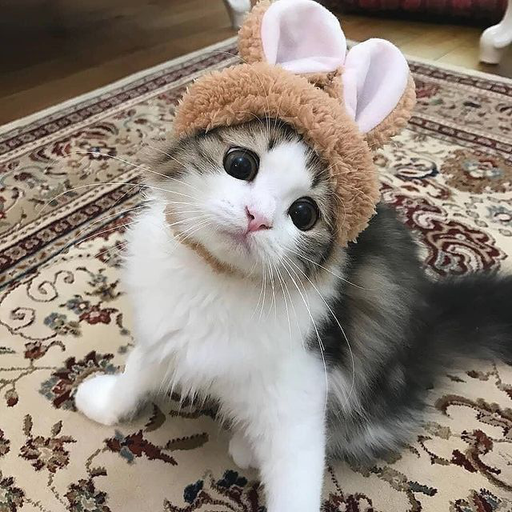

In [1]:
# !python3 -m pip install --upgrade Pillow
import PIL
from PIL import Image, ImageDraw
img = Image.open("data/cats/165485740_301004848048445_3644757285687817953_n.jpg")
img.thumbnail((512,512), PIL.Image.ANTIALIAS)
img

# Image Masking

In [2]:
class Layout: 
    """Yield rectangular shapes over image"""
    pass

class Perturbation: pass


class FixedLayout(Layout):
    """Mask given (fixed) part of image."""

    def __init__(self, *, masks):
        self.masks = masks
    
    def __call__(self, img):
        w, h = img.size
        for (x0, y0, x1, y1) in self.masks:
            yield (int(x0*w), int(y0*h), int(x1*w), int(y1*h))
            

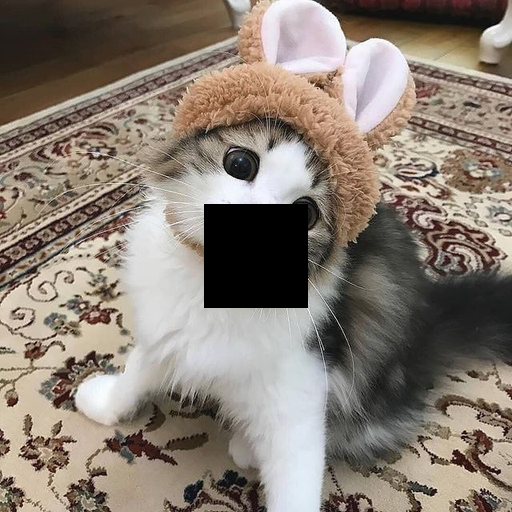

In [3]:
import random

class BlackBoxMasking(Perturbation):
    """Mask image with black (or `color`) rectangles."""

    def __init__(self, *, color: str = 'black', layout):
        self.color = color
        self.layout = layout
        
    def __call__(self, img: Image) -> Image:
        out = img.copy()
        draw = ImageDraw.Draw(out)
        for pos in self.layout(img):
            draw.rectangle(pos, fill=self.color)
        return out
    
# mask center of image
BlackBoxMasking(layout=FixedLayout(masks=[(0.4, 0.4, 0.6, 0.6)]))(img)

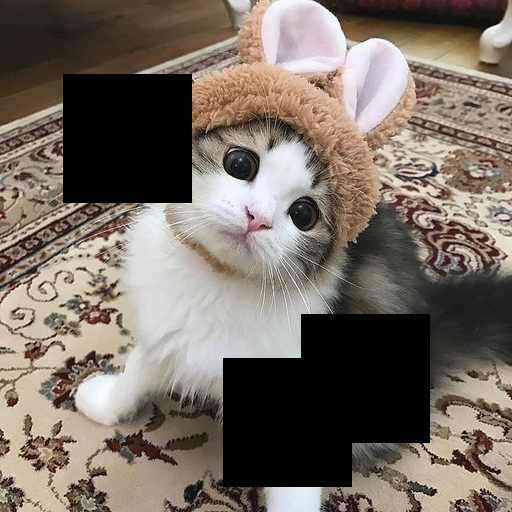

In [4]:
from typing import Tuple

class FixedShapeLayout(Layout):
    """Return `count` rectangles of given fixed `shape`."""

    def __init__(self, *, count: int = 1, shape: Tuple[int, int]):
        self.count = count
        self.shape = shape
        
    def __call__(self, img):
        w, h = img.size
        pw, ph = self.shape
        for _ in range(self.count):
            x0 = random.randint(0, w-pw)
            y0 = random.randint(0, h-ph)
            x1 = x0 + pw
            y1 = y0 + ph
            yield [x0, y0, x1, y1]
            
BlackBoxMasking(layout=FixedShapeLayout(count=3, shape=(128, 128)))(img)

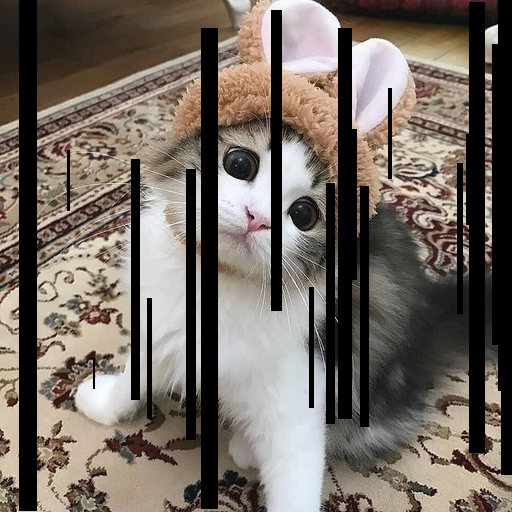

In [5]:
class FixedRatioLayout(Layout):
    """Return `count` rectangels of given size `ratio` (width/height)."""

    def __init__(self, count: int = 1, ratio: float = 1.0):
        self.count = count
        self.ratio = ratio
        
    def __call__(self, img):
        w, h = img.size
        for _ in range(self.count):
            pw = random.randint(1, min(img.size[0], int(img.size[1]*self.ratio)))
            ph = int(pw/self.ratio)
            
            x0 = random.randint(0, w-pw)
            y0 = random.randint(0, h-ph)
            x1 = x0 + pw
            y1 = y0 + ph
            
            yield [x0, y0, x1, y1]
            
BlackBoxMasking(layout=FixedRatioLayout(count=20, ratio=1/30))(img)

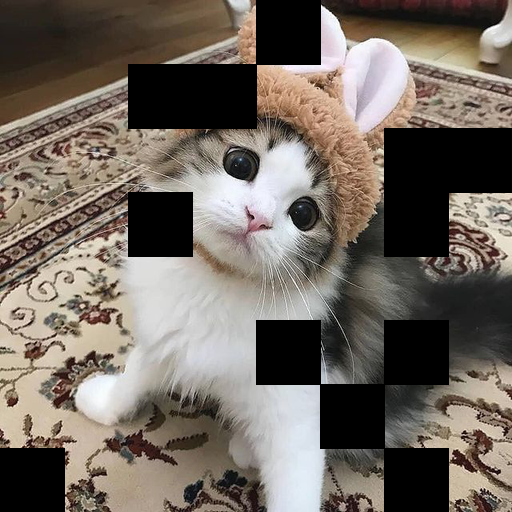

In [6]:
from typing import Iterator
from itertools import product


class GridLayout(Layout):
    """Mask given `perc` of grid (of size `grid_size`)."""

    def __init__(self, *, perc: float = 0.2, grid_size: int = 8):
        self.perc = perc
        self.grid_size = grid_size
    
    def __call__(self, img) -> Iterator[Tuple[int,int,int,int]]:
        cells = list(product(range(self.grid_size), repeat=2))
        random.shuffle(cells)
        cells = cells[:int(len(cells)*self.perc)]
        
        w, h = img.size
        for x, y in cells:
            x0 = int(w*x/self.grid_size)
            y0 = int(h*y/self.grid_size)
            x1 = int(w*(x+1)/self.grid_size)
            y1 = int(h*(y+1)/self.grid_size)
            yield [x0,y0,x1,y1]

BlackBoxMasking(layout=GridLayout(perc=0.2, grid_size=8))(img)

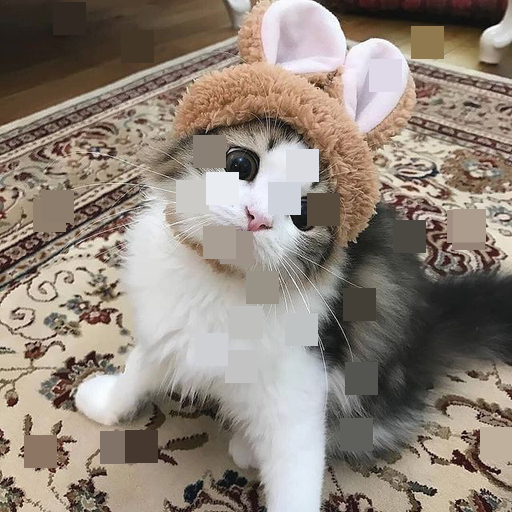

In [7]:
from PIL import ImageStat

class MedianMasking(Perturbation):
    """Mask with rectangles with median color."""

    def __init__(self, layout: Layout):
        self.layout = layout

    def __call__(self, img: Image) -> Image:
        out = img.copy()
        draw = ImageDraw.Draw(out)
        for pos in self.layout(img):
            stat = ImageStat.Stat(img.crop(pos))
            draw.rectangle(pos, fill=tuple(stat.median))
        return out

MedianMasking(layout=FixedShapeLayout(count=30, shape=(32,32)))(img)

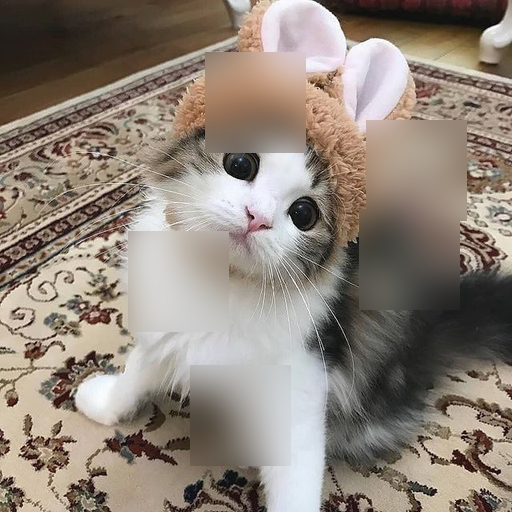

In [8]:
from PIL import ImageFilter

class BlurMasking(Perturbation):
    """Mask with blured rectangles."""

    def __init__(self, *, blur: int = 16, layout: Layout):
        self.layout = layout
        self.blur = blur
    
    def __call__(self, img: Image) -> Image:
        blur = img.filter(ImageFilter.GaussianBlur(self.blur))
        mask = Image.new('L', img.size, 'white')
        draw = ImageDraw.Draw(mask)
        for pos in self.layout(img):
            draw.rectangle(pos, fill='black')
        return Image.composite(img, blur, mask)

BlurMasking(layout=FixedShapeLayout(count=5, shape=(100, 100)), blur=16)(img)

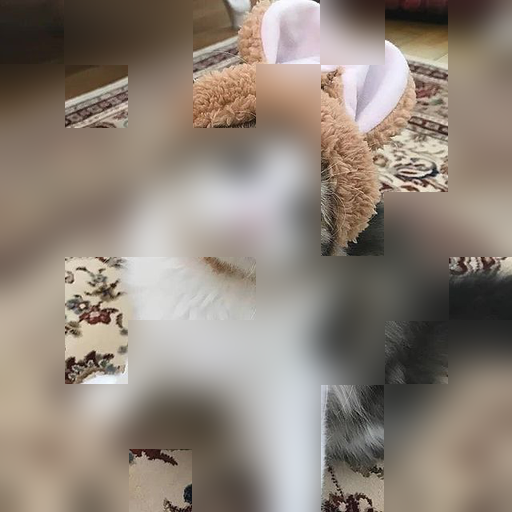

In [9]:
BlurMasking(layout=GridLayout(perc=0.7, grid_size=8), blur=16)(img)

# Color Manipulation

In [10]:
from typing import Tuple

class HSVFilter(Perturbation):
    def _map(self, pixel: Tuple[int, int, int]) -> Tuple[int,int,int]:
        return pixel

    def __call__(self, img: Image) -> Image:
        out = img.convert('HSV')
        pixels = out.load() # create the pixel map
        w, h = out.size
        for y in range(h):
            for x in range(w):
                pixels[x, y] = self._map(pixels[x,y])
            
        return out.convert(img.mode)

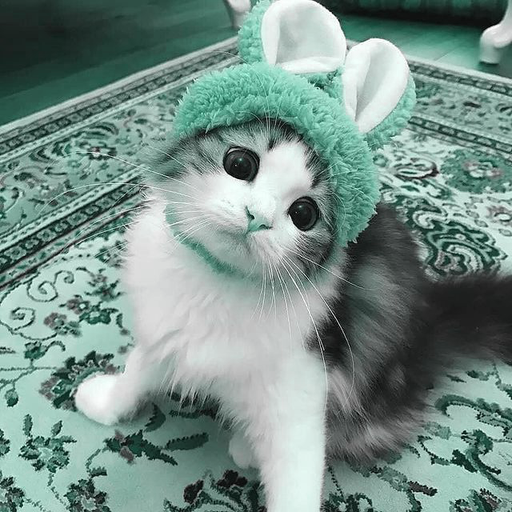

In [11]:
class Colorize(HSVFilter):
    def __init__(self, hue: int = None):
        self._orig_hue = hue
        
    def _map(self, pixel):
        return (self.hue, ) + pixel[1:]

    def __call__(self, img):
        self.hue = self._orig_hue if self._orig_hue is not None else random.randint(0, 255)
        return super().__call__(img)

Colorize()(img)

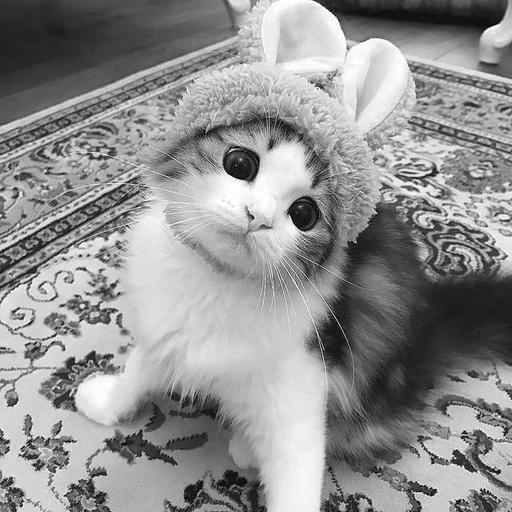

In [12]:
class Grayscale(HSVFilter):
    def _map(self, pixel):
        return (pixel[0], 0, pixel[2])
    
Grayscale()(img)

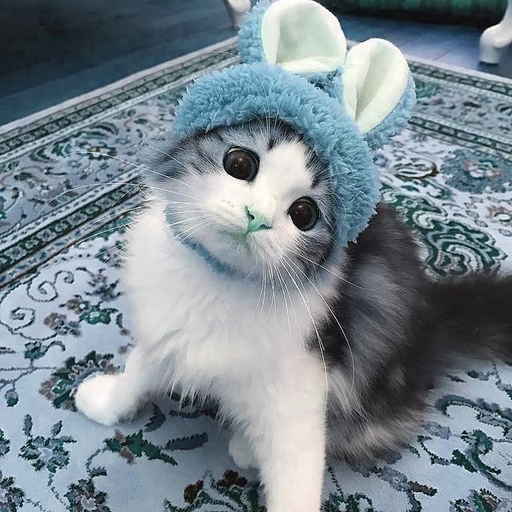

In [13]:
class HueRotate(HSVFilter):
    def __init__(self, angle: int = None):
        self._orig_angle = angle
    
    def _map(self, pixel):
        return ((pixel[0] + self.angle)%255, pixel[1], pixel[2])
    
    def __call__(self, img: Image) -> Image:
        self.angle = self._orig_angle if self._orig_angle is not None else random.randint(0, 255)
        return super().__call__(img)

HueRotate()(img)

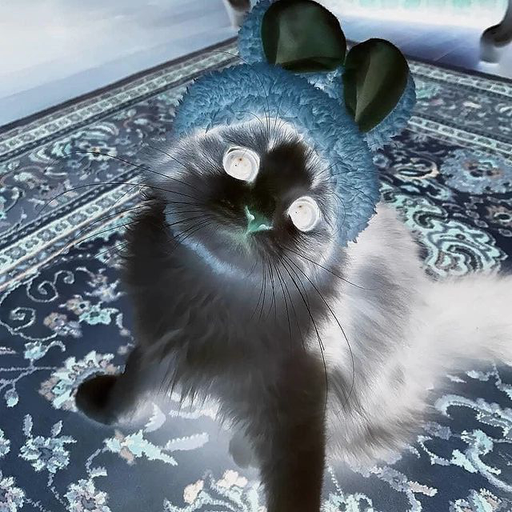

In [14]:
import colorsys

class InvertColor(HSVFilter):
    def _map(self, pixel):
        r, g, b = colorsys.hsv_to_rgb(pixel[0]/255, pixel[1]/255, pixel[2]/255)
        h, s, v = colorsys.rgb_to_hsv(1 - r, 1 - g, 1 - b)
        return (int(255*h), int(255*s), int(255*v))

InvertColor()(img)

# Introduce Random Noise

In [15]:
class AlphaBlend(Perturbation):
    def __init__(self, *, alpha: float = 0.1):
        self.alpha = alpha
        
    def _get_mask(self, img):
        return img
    
    def __call__(self, img: Image) -> Image:
        mask = self._get_mask(img)
        return Image.blend(
            img, mask, self.alpha
        ) 

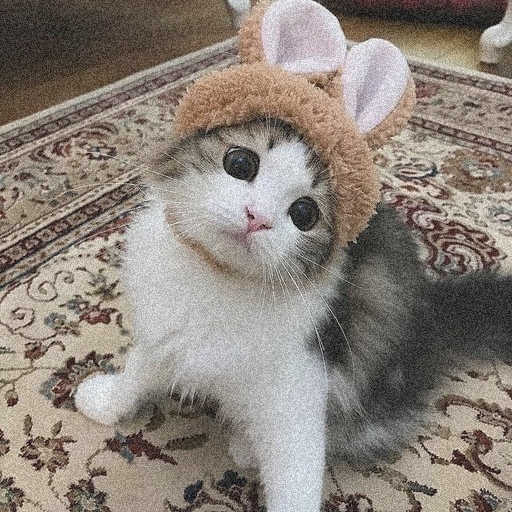

In [16]:
class BlackWhiteNoise(AlphaBlend):
    def _get_mask(self, img):
        noise = Image.new('L', img.size)
        pixels = noise.load()
        w, h = img.size
        for y in range(h):
            for x in range(w):
                pixels[x, y] = random.randint(0, 255)
        return noise.convert(img.mode)

BlackWhiteNoise(alpha=0.2)(img)

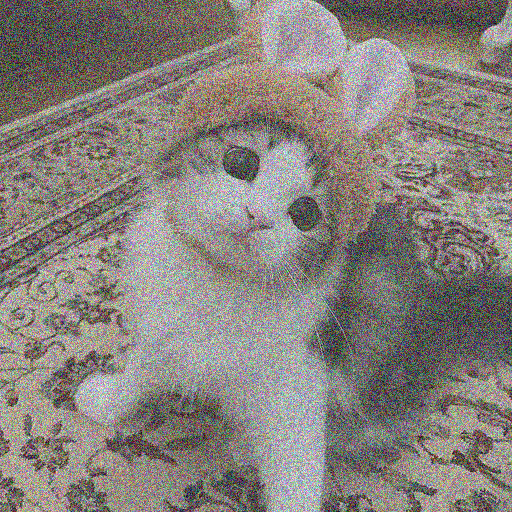

In [17]:
class RGBNoise(AlphaBlend):
    def _get_mask(self, img):
        noise = Image.new('RGB', img.size)
        pixels = noise.load()
        w, h = img.size
        for y in range(h):
            for x in range(w):
                pixels[x, y] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        return noise.convert(img.mode)

RGBNoise(alpha=0.5)(img)

## TODO: https://github.com/aleju/imgaug ?

# Random Perturbation

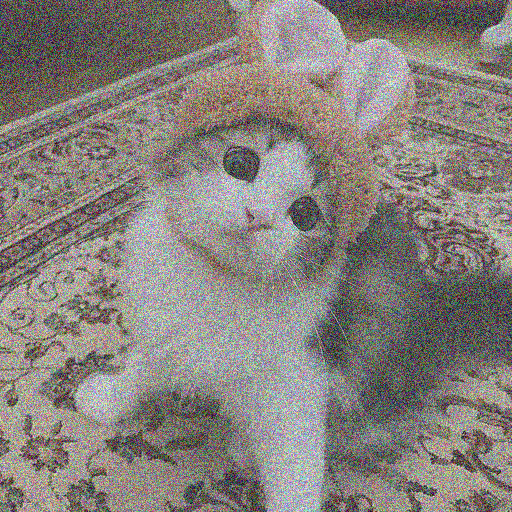

In [18]:
from typing import Dict

class RandomPerturbation(Perturbation):
    def __init__(self, perturbations: Dict[Perturbation, int]):
        self.perturbations = list(perturbations.keys())
        self.weights = list(perturbations.values())
        
    def __call__(self, img: Image) -> Image:
        p = random.choices(self.perturbations, weights=self.weights)[0]
        return p(img)
    
RandomPerturbation({
    InvertColor(): 1,
    RGBNoise(alpha=0.5): 1
})(img)

# Load all images and generate perturbations

In [19]:
import glob
all_imgs = list(map(Image.open, glob.glob('data/cats/*.jpg')))

In [20]:
import ipywidgets as widgets
import io 

N = 40
n_cols = 4

# Generate random perturbation
rp = RandomPerturbation({
    BlackBoxMasking(layout=FixedLayout(masks=[(0.4, 0.4, 0.6, 0.6)])): 1,
    BlackBoxMasking(layout=FixedShapeLayout(count=3, shape=(128, 128))): 1,
    BlackBoxMasking(layout=FixedRatioLayout(count=20, ratio=1/30)): 1,
    BlackBoxMasking(layout=GridLayout(perc=0.2, grid_size=8)): 1,
    MedianMasking(layout=FixedShapeLayout(count=30, shape=(32,32))): 1, 
    BlurMasking(layout=FixedShapeLayout(count=5, shape=(100, 100)), blur=16): 1,
    BlurMasking(layout=GridLayout(perc=0.7, grid_size=8), blur=16): 1,
    Colorize(): 1,
    Grayscale(): 1,
    HueRotate(): 1,
    InvertColor(): 1,
    BlackWhiteNoise(alpha=0.2): 1,
    RGBNoise(alpha=0.5): 1
})


for i in range(N):
    img = random.choice(all_imgs)
    img = rp(img)
    img.save(f'samples/{i:2d}.jpg')

## Show perturbations

In [21]:
rows = []
items = list(range(N))
for i in range(0, len(items), n_cols):
    row = []
    for i in items[i:i+n_cols]:
        with open(f'samples/{i:2d}.jpg', 'rb') as file:
            image = widgets.Image(
                value=file.read(), width=200, height=200
            )     
            row.append(image)
    rows.append(widgets.HBox(row))
widgets.VBox(rows)